## value iteration for control
Sawyer B. Fuller
lecture material for U. Washington course ME586: Biology-inspired robotics


Dynamics system is an un-damped pendulum, where $u$ is the input and $\tau_d$ is a (zero-mean, Gaussian) torque disturbance. Here we are defining $\theta$ to be the angle away from pointing straight downward.  
$$ \ddot{\theta} = -\frac{g}{l} \sin{\theta} + \frac{u}{m l^2}$$
Linearized at the state $[\theta, \dot{\theta}]^T = [0, 0]^T$:
$$
\dot{q} =
\begin{bmatrix}
\dot{\theta} \\
\ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
0 & 1\\
-\frac{g}{l} & 0\\
\end{bmatrix} 
\begin{bmatrix}
\theta \\
\dot{\theta}
\end{bmatrix}+ 
\begin{bmatrix}
0 \\
\frac{1}{ml^2} 
\end{bmatrix} u
$$ 
$$
y =
\begin{bmatrix}
1 && 0 \\
\end{bmatrix}
\begin{bmatrix}
\theta \\
\dot{\theta}
\end{bmatrix} + 0 
$$

The D matrix is 0 because there is no feed-through. The disturbance torque is also included in this model.

The system output only directly measures the angular position $\theta$ and not the angular rate $\dot{\theta}$.

#TODO: I don't think iterated Jstar should look like a round bowl

In [1]:
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy as sp

In [249]:
m = .1
l = 3
sensor_noise_std = .1

def dynamics(t, q, u=0):
    theta, thetadot  = q[0], q[1]
    return np.array((thetadot, -9.81/l*np.sin(theta) + u/(m*l**2)))

dt = 0.1
def discrete_dynamics(t, q, u):
    return q + dt*dynamics(t, q, u) 

A = np.array(((0, 1),
         (-9.81/l, 0)))
C = np.array(((1, 0),))
B = np.array(((0,), (1/(m*l**2),)))

def linearized_dynamics(t, q, u=(0,)):
    return A @ q + B @ u
def discrete_linearized_dynamics(t, q, u=(0,)):
    return q + dt*linearized_dynamics(t,q, u)

Q = np.eye(2)
R = .005
K = ct.lqr(A, B, Q, R)[0]

def linear_feedback_dynamics(t, q, u=(0,)):
    return (A - B @ K) @ q
def ell_quadratic(q, u): # instantaneous cost
    #return q.T@Q@q + u.T@R@u
    return q[0]**2 + q[1]**2 + R * u**2

In [326]:
maxtheta = 2*np.pi
maxthetadot = 6
ntheta = 61
nthetadot = 41
theta_space = np.linspace(-maxtheta, maxtheta, ntheta)
thetadot_space = np.linspace(-maxthetadot, maxthetadot, nthetadot)
theta_interpolator = sp.interpolate.interp1d(theta_space, range(ntheta), kind='nearest', fill_value='extrapolate')
thetadot_interpolator = sp.interpolate.interp1d(thetadot_space, range(nthetadot), kind='nearest', fill_value='extrapolate')

Smooth plot of pure lqr control of linear system

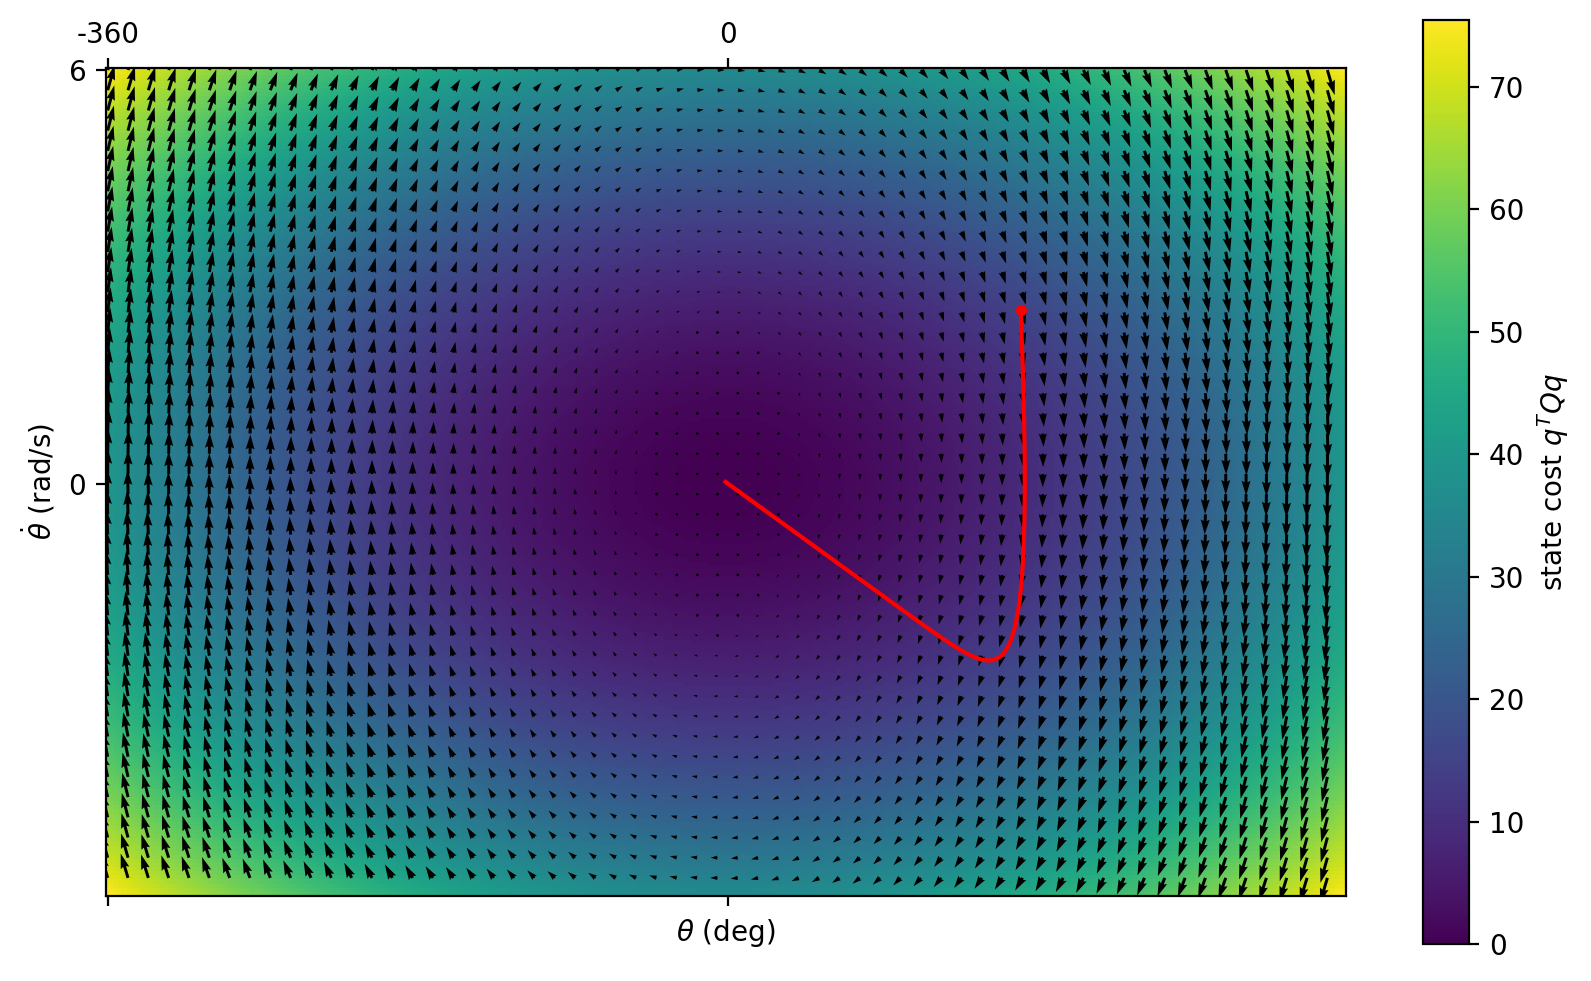

In [251]:
# calculate state cost for smooth lqr 
plt.figure(figsize=(10, 6)) 
ntheta_s = 301
theta_space_s = np.linspace(-maxtheta, maxtheta, ntheta_s)
nthetadot_s = 201
thetadot_space_s = np.linspace(-maxthetadot, maxthetadot, nthetadot_s)
state_cost_lqr = np.zeros((ntheta_s, nthetadot_s))
for itheta, theta in enumerate(theta_space_s):
    for ithetadot, thetadot in enumerate(thetadot_space_s):
        state_cost_lqr[itheta, ithetadot] = Q[0,0]*theta**2 + Q[1,1]*thetadot**2 
if 1:
    X, Y = np.meshgrid(np.arange(ntheta)*ntheta_s/ntheta, np.arange(nthetadot)*nthetadot_s/nthetadot)
    U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
    for row in range(ntheta):
        for col in range(nthetadot):
            U[row, col] = -linearized_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
            V[row, col] = linearized_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
    plt.quiver(X.T, Y.T, U, V)

if 1:
    plt.matshow(state_cost_lqr[:,::-1].T,0)
    colorbar = plt.colorbar()
    colorbar.set_label(r'state cost $q^TQq$')
plt.xticks((0, ntheta_s/2, ntheta_s), (-int(np.rad2deg(maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot_s/2, nthetadot_s), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')

if 1:
    traj = sp.integrate.solve_ivp(linear_feedback_dynamics, t_span=[0, 10], y0=(3,2.5), max_step=0.01)
    scale = (ntheta_s//2/maxtheta, nthetadot_s//2/maxthetadot)
    offset = (ntheta_s//2, nthetadot_s//2)
    plt.plot(traj.y[0]*scale[0]+offset[0],-traj.y[1]*scale[1]+offset[1], 'r')
    plt.plot(traj.y[0,0]*scale[0]+offset[0],-traj.y[1,0]*scale[1]+offset[1], 'r.')
plt.show()


value iteration for LQR

In [351]:
Jstar_LQR = np.zeros((ntheta, nthetadot))
deltathetadotmax = 4 # distance along vertical direction (in J indices) u can act
nu = 2*deltathetadotmax+1
umax = m * l**2 / dt * deltathetadotmax
print(f'{umax=}')
#u_space = np.linspace(-int(nu/2), int(nu/2), nu) 
u_space = np.linspace(-umax, umax, nu) 
print(u_space)

# do value iteration
for i in range(50):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_linearized_dynamics(0, q, (u,))
                # the following doesn't work for some reason
                #new_Jstar_indices = (np.clip(round((new_q[0]+maxtheta)/dtheta), -ntheta//2, ntheta//2), \
                #                     np.clip(round((new_q[1]+maxthetadot)/dthetadot), -nthetadot//2, nthetadot//2),)
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell_quadratic(q, u) + Jstar_LQR[new_Jstar_indices])
            Jstar_LQR[itheta, ithetadot] = min(J)

umax=36.0
[-36. -27. -18.  -9.   0.   9.  18.  27.  36.]


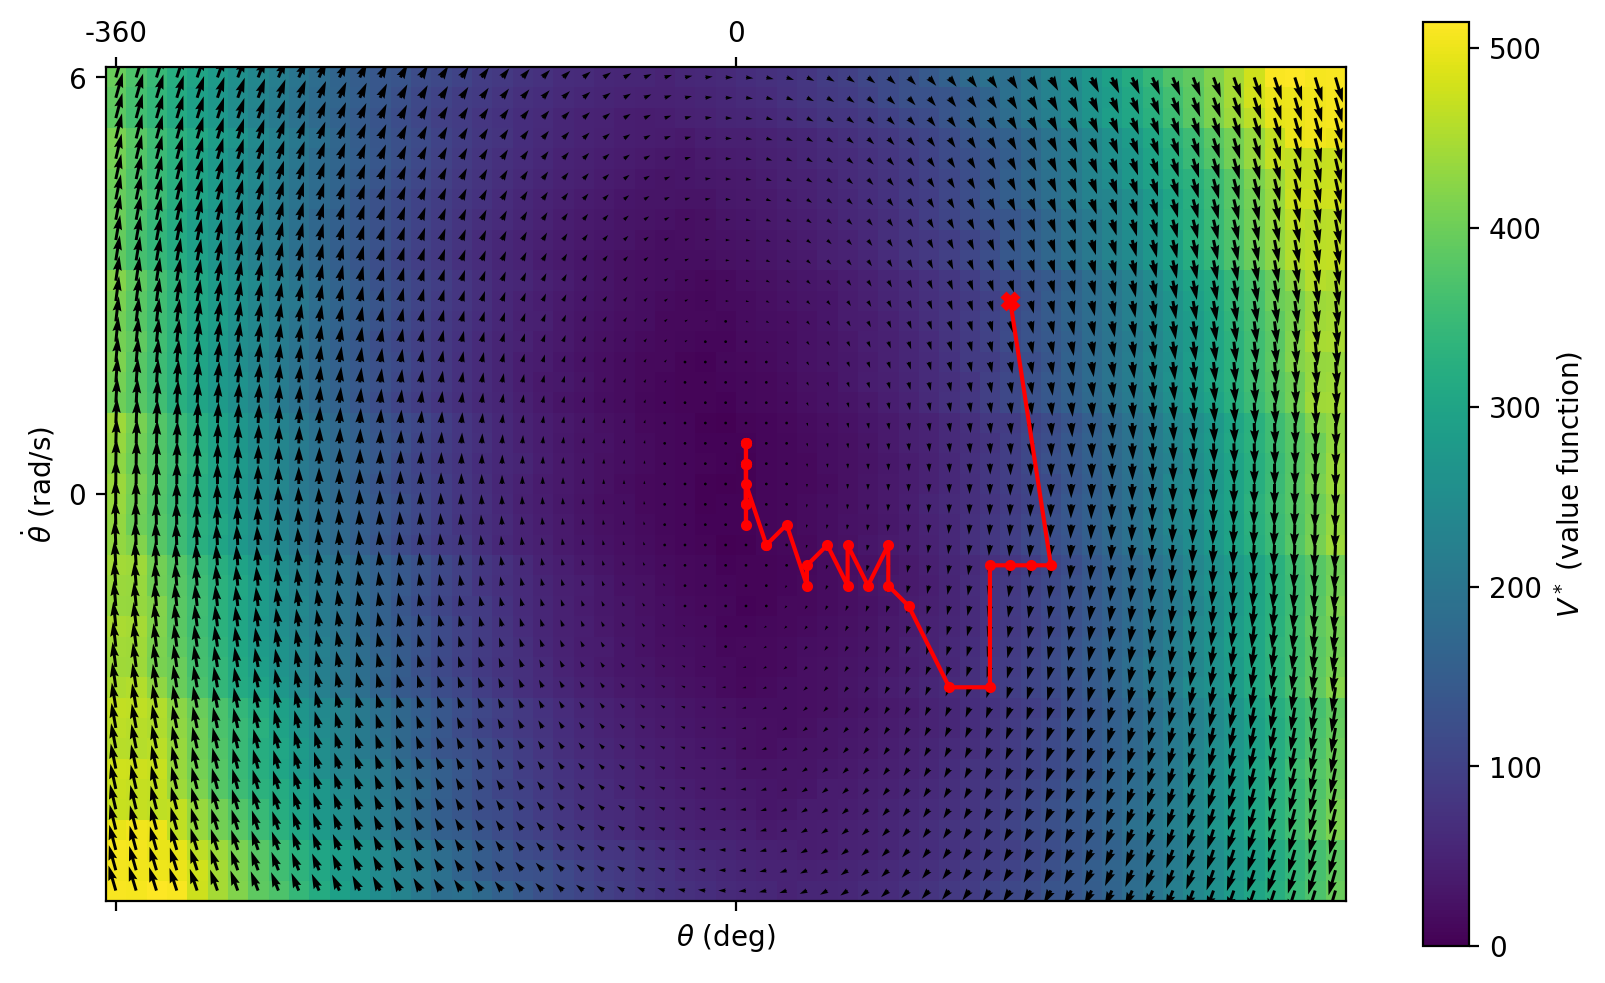

In [352]:

plt.figure(figsize=(10, 6))
if 1:
    X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
    U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
    for row in range(ntheta):
        for col in range(nthetadot):
            U[row, col] = -linearized_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
            V[row, col] = linearized_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
    plt.quiver(X.T, Y.T, U, V)
if 1:
    plt.matshow(Jstar_LQR[:,::-1].T,0)
    colorbar = plt.colorbar()
    colorbar.set_label(r'$V^*$ (value function)')
plt.xticks((0, ntheta/2, ntheta), (-int(np.rad2deg(maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2, nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')

if 1: 
    # dynamics
    q_data = []
    q_data.append((3,2.5)) # initial condition
    J_indices_data = []
    J_indices_data.append((int(theta_interpolator(q_data[-1][0])), int(thetadot_interpolator(q_data[-1][1]))))
    for t in range(30):
        # find u that minimizes next cost to go
        J = []
        J_indices = []
        qs = []
        q = q_data[-1]
        for u in u_space:
            test_q = discrete_linearized_dynamics(0, q, (u,))
            test_indices = (int(theta_interpolator(test_q[0])), int(thetadot_interpolator(test_q[1])))
            qs.append(test_q)
            J_indices.append(test_indices)
            J.append(ell_quadratic(q, u) + Jstar_LQR[test_indices])
        best_u_index = np.argmin(J)
        q_data.append(qs[best_u_index])
        J_indices_data.append(J_indices[best_u_index])
    J_indices_data = np.asarray(J_indices_data)
    plt.plot(J_indices_data[:,0], nthetadot-J_indices_data[:,1]-2, 'r.-')    
    plt.plot(J_indices_data[0,0], nthetadot-J_indices_data[0,1]-2, 'rX')

Value iteration for inverted pendulum. with limited u. 

Now we are defining $\theta$ to be the angle away from pointing straight upward (unstable equilibrium).  
$$ \ddot{\theta} = \frac{g}{l} \sin{\theta} + \frac{u}{m l^2}$$
or
$$
\dot{q} =
\begin{bmatrix}
\dot{\theta} \\
\ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
\dot \theta \\
\frac{g}{l}\sin{\theta} + u\frac{1}{ml^2}\\
\end{bmatrix} 
$$ 


In [272]:
def shifted_dynamics(t, q, u=0):
    theta, thetadot  = q[0], q[1]
    return np.array((thetadot, 9.81/l*np.sin(theta) + u/(m*l**2)))

def discrete_shifted_dynamics(t, q, u):
    return q + dt*shifted_dynamics(t, q, u) 

# minimum-time instantaneous cost (no cost on u)
def ell_mintime(q, u): # instantaneous cost
    # only reward if at the origin
    return 0 if (round(q[0]*10), round(q[1]*10)) == (0, 0) else 1

umax=0.45
[-0.45  0.    0.45]


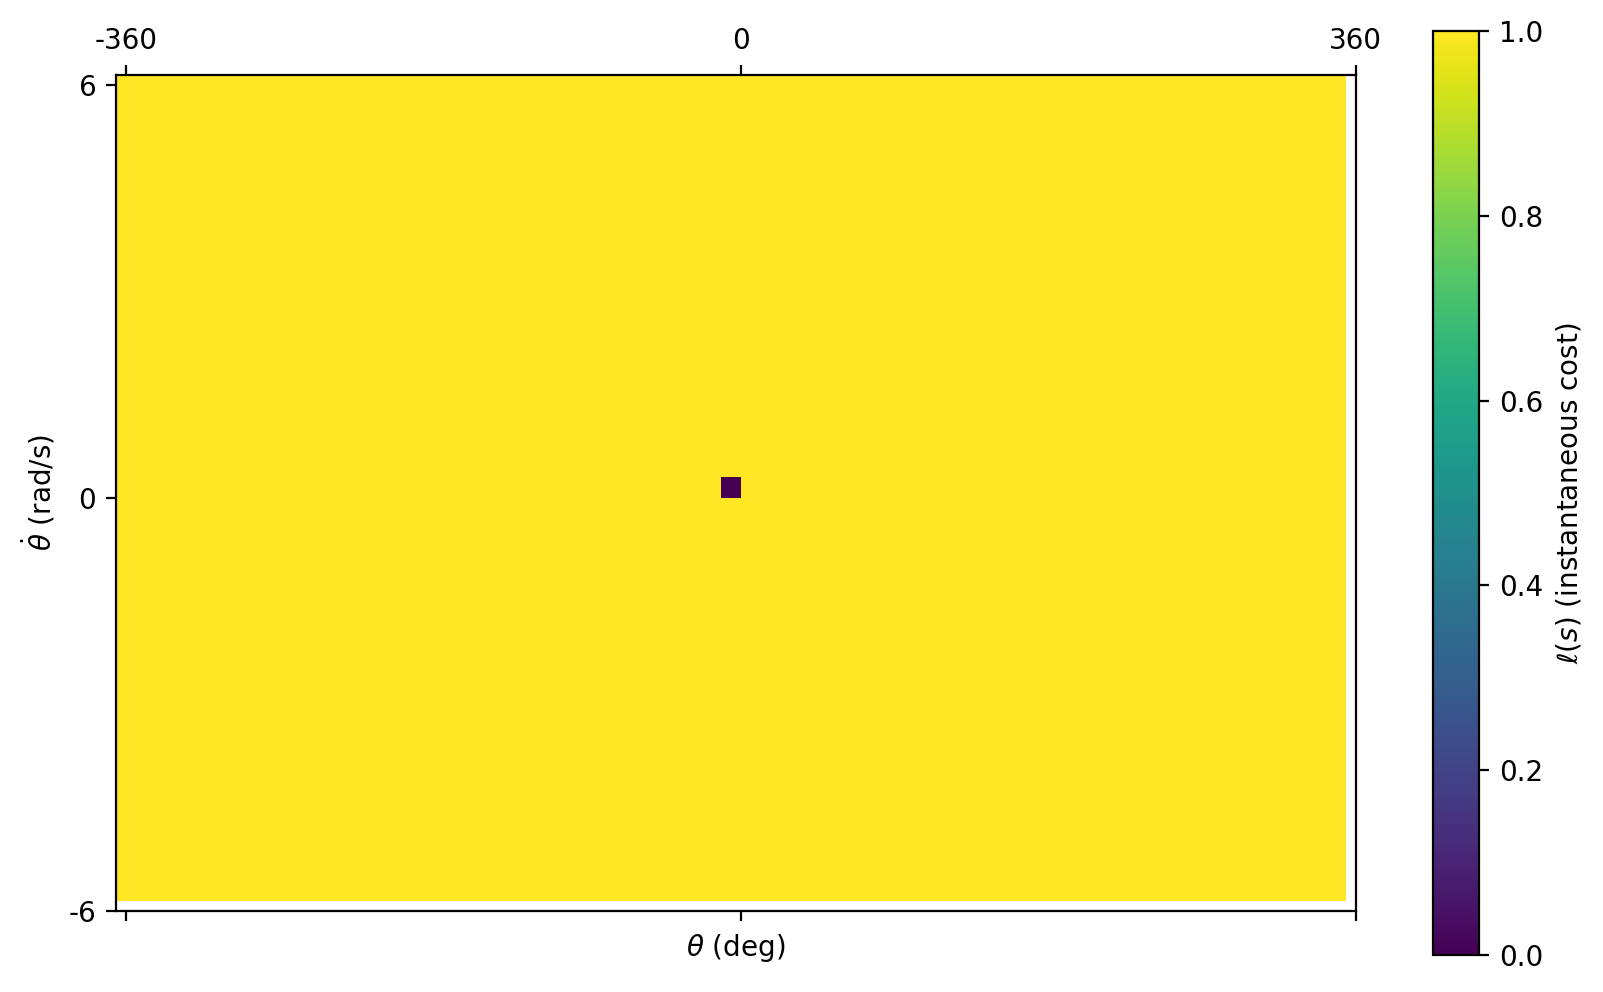

In [348]:
# plot with just ell
plt.figure(figsize=(10, 6))
ellmat = np.empty((ntheta, nthetadot))
for itheta, theta in enumerate(theta_space):
    for ithetadot, thetadot in enumerate(thetadot_space):
        ellmat[itheta, ithetadot] = ell_mintime((theta, thetadot), 0)
plt.matshow(ellmat.T,0)
plt.xticks((0, ntheta/2, ntheta), (int(np.rad2deg(-maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2, nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')
colorbar = plt.colorbar()
colorbar.set_label(r'$\ell(s)$ (instantaneous cost)')

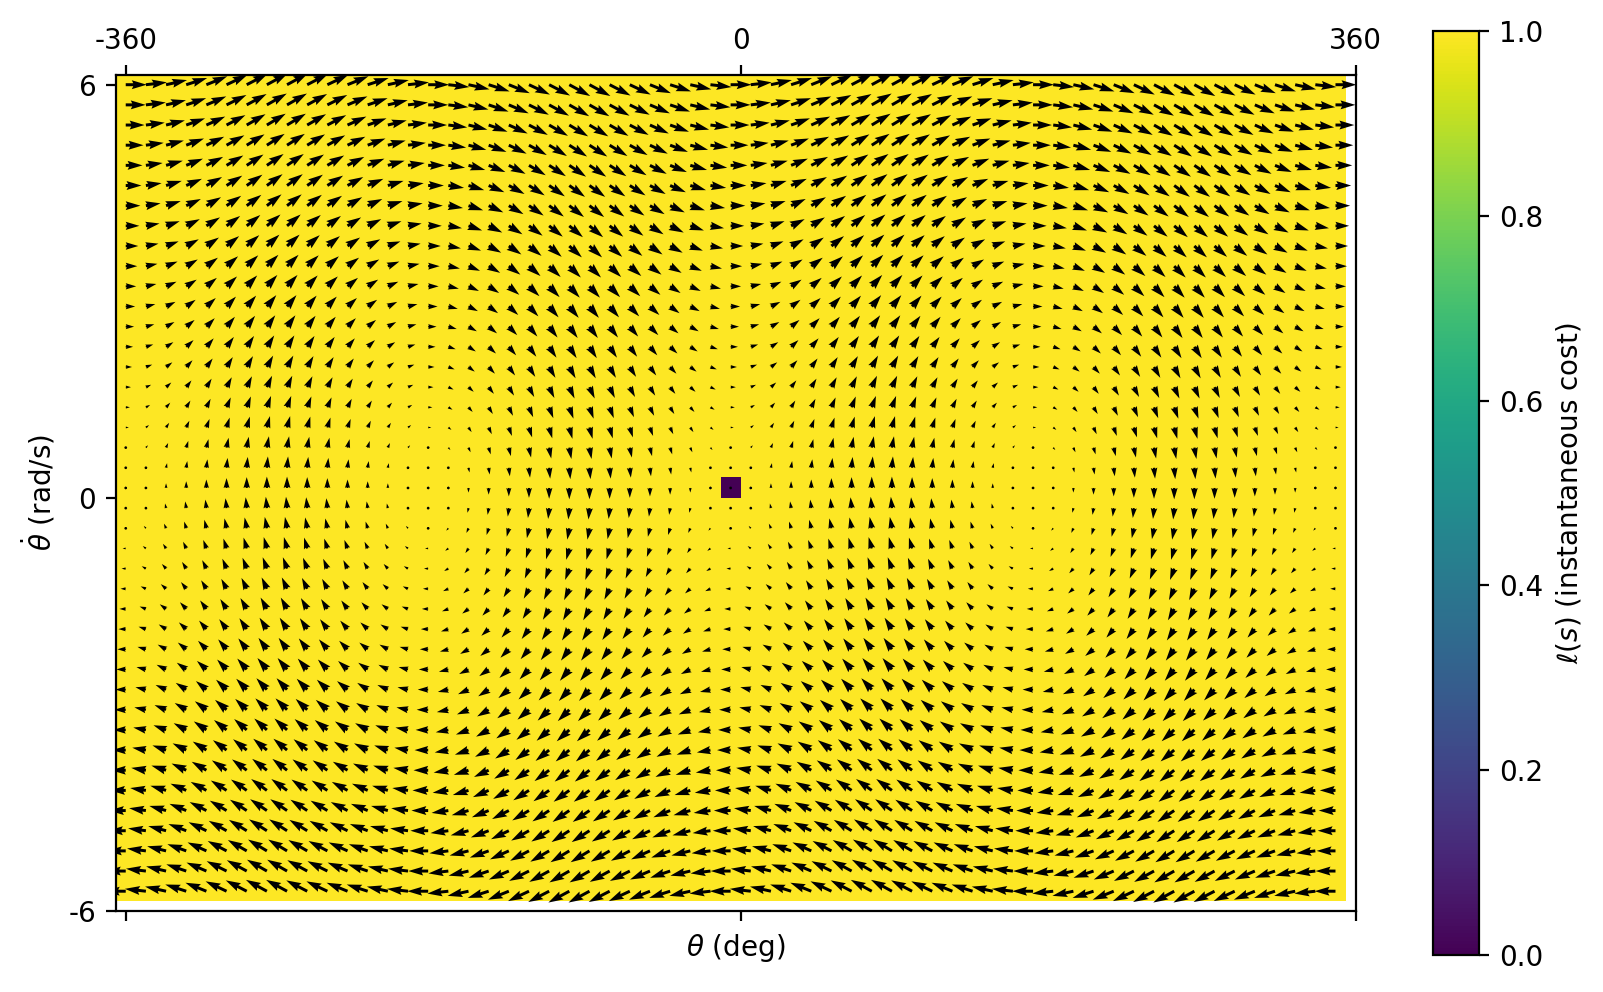

In [274]:
# cost function with dynamics superimposed
plt.figure(figsize=(10, 6))
if 1:
    X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
    U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
    for row in range(ntheta):
        for col in range(nthetadot):
            U[row, col] = -shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
            V[row, col] = shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
    plt.quiver(X.T, Y.T, U, V)
ellmat = np.empty((ntheta, nthetadot))
for itheta, theta in enumerate(theta_space):
    for ithetadot, thetadot in enumerate(thetadot_space):
        ellmat[itheta, ithetadot] = ell_mintime((theta, thetadot), 0)
plt.matshow(ellmat.T,0)
plt.xticks((0, ntheta/2, ntheta), (int(np.rad2deg(-maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2, nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')
colorbar = plt.colorbar()
colorbar.set_label(r'$\ell(s)$ (instantaneous cost)')

In [336]:
deltathetadotmax = 0.3 # distance along vertical direction u can act
nu = 3
umax = m * l**2 / dt * deltathetadotmax
print(f'{umax=}')
#u_space = np.linspace(-int(nu/2), int(nu/2), nu) 
u_space = np.linspace(-umax, umax, nu) 
print(u_space)

umax=2.6999999999999997
[-2.7  0.   2.7]


In [337]:
Jstar_mintime = np.zeros((ntheta, nthetadot))
    
# do value iteration
for i in range(60):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_shifted_dynamics(0, q, u)
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell_mintime(q, u) + Jstar_mintime[new_Jstar_indices])
            Jstar_mintime[itheta, ithetadot] = min(J)

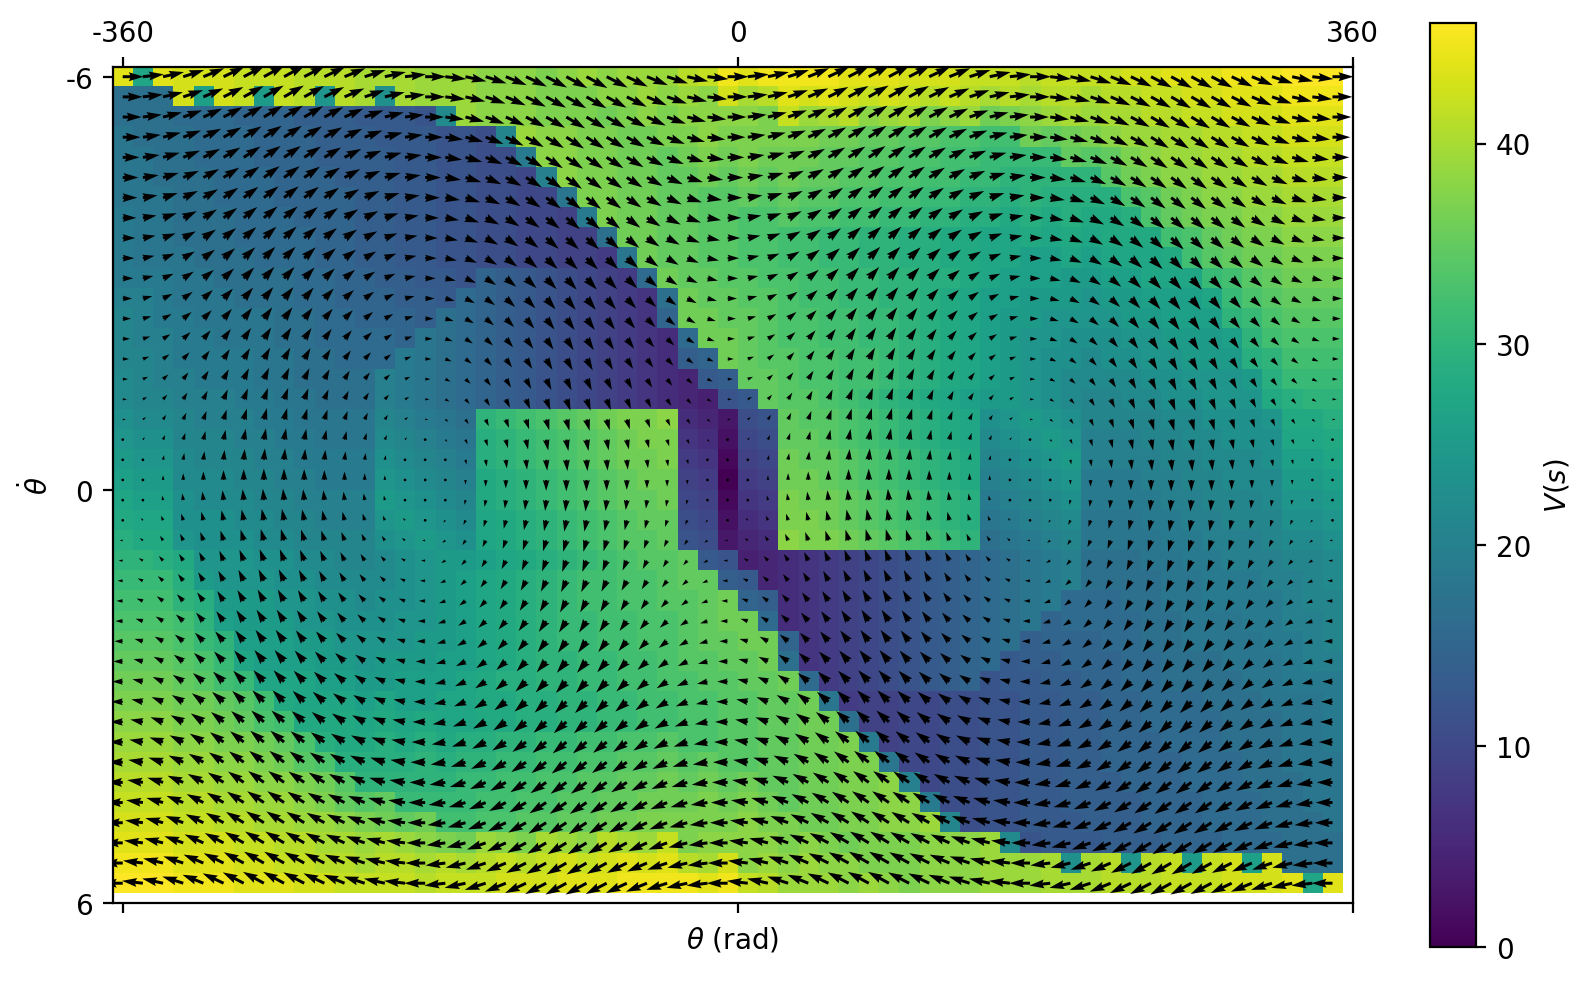

In [349]:
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = -shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
        V[row, col] = shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar_mintime[:,::-1].T,0)
plt.xticks((0, ntheta/2, ntheta), (int(np.rad2deg(-maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (rad)')
plt.yticks((0, nthetadot/2, nthetadot), (-maxthetadot, 0, maxthetadot))
plt.ylabel(r'$\dot{\theta}$')
colorbar = plt.colorbar()
colorbar.set_label(r'$V(s)$')


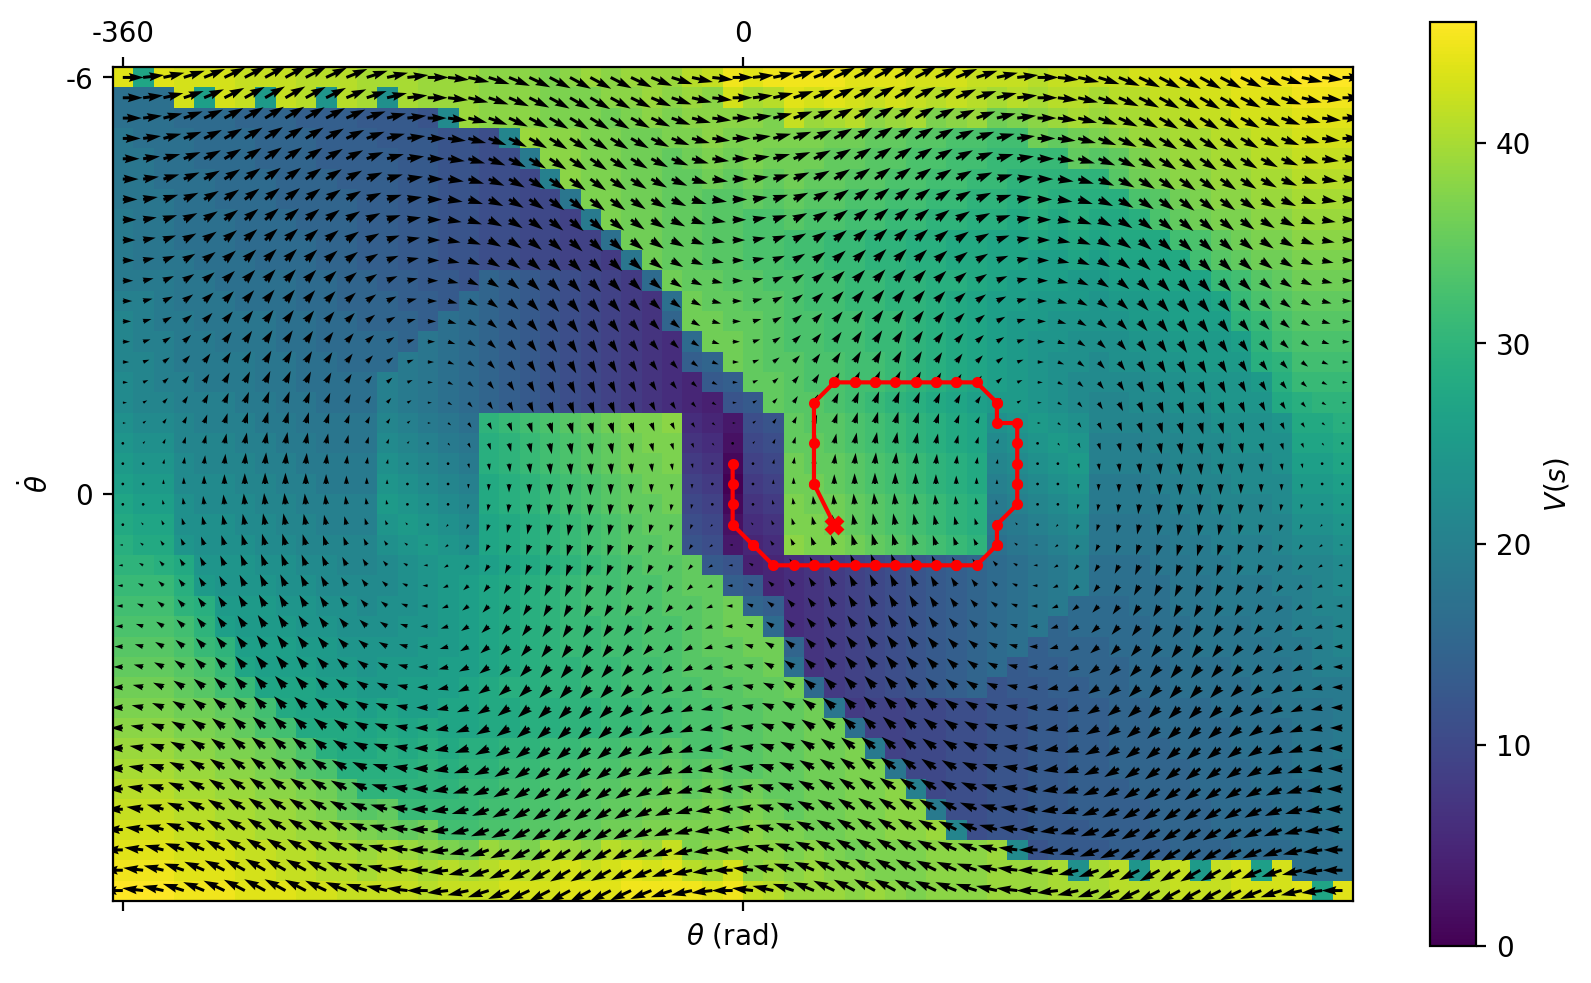

In [350]:
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = -shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
        V[row, col] = shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar_mintime[:,::-1].T,0)
plt.xticks((0, ntheta/2, ntheta), (int(np.rad2deg(-maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (rad)')
plt.yticks((0, nthetadot/2, nthetadot), (-maxthetadot, 0, maxthetadot))
plt.ylabel(r'$\dot{\theta}$')
colorbar = plt.colorbar()
colorbar.set_label(r'$V(s)$')

if 1: 
    # example trajectory
    q_data = []
    q_data.append((1,-1)) # initial condition
    J_indices_data = []
    J_indices_data.append((int(theta_interpolator(q_data[-1][0])), int(thetadot_interpolator(q_data[-1][1]))))
    for t in range(50):
        # find u that minimizes next cost to go
        J = []
        J_indices = []
        qs = []
        q = q_data[-1]
        for u in u_space:
            test_q = discrete_shifted_dynamics(0, q, u)
            test_indices = (int(theta_interpolator(test_q[0])), int(thetadot_interpolator(test_q[1])))
            qs.append(test_q)
            J_indices.append(test_indices)
            J.append(ell_mintime(q, u) + Jstar_mintime[test_indices])
        best_u_index = np.argmin(J)
        q_data.append(qs[best_u_index])
        J_indices_data.append(J_indices[best_u_index])
    J_indices_data = np.asarray(J_indices_data)
    plt.plot(J_indices_data[:,0], nthetadot-J_indices_data[:,1]-2, 'r.-')    
    plt.plot(J_indices_data[0,0], nthetadot-J_indices_data[0,1]-2, 'rX')

## old stuff

value iteration for down-hanging nonlinear pendulum

In [ ]:
dthetadot = thetadot_space[1]-thetadot_space[0]
deltathetadotmax = 10 # distance along vertical direction u can act
nu = 2*deltathetadotmax+1
umax = m * l**2 / dt * deltathetadotmax
print(f'{umax=}')
#u_space = np.linspace(-int(nu/2), int(nu/2), nu) 
u_space = np.linspace(-umax, umax, nu)  
def ell(q, u): # instantaneous cost
    #return q.T@Q@q + u.T@R@u
    return q[0]**2 + q[1]**2 + R * u**2

umax=10.0


In [6]:

Jstar = np.zeros((ntheta, nthetadot))
    
# do value iteration
for i in range(30):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_dynamics(0, q, u)
                # the following doesn't work for some reason
                #new_Jstar_indices = (np.clip(round((new_q[0]+maxtheta)/dtheta), -ntheta//2, ntheta//2), \
                #                     np.clip(round((new_q[1]+maxthetadot)/dthetadot), -nthetadot//2, nthetadot//2),)
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell(q, u) + Jstar[new_Jstar_indices])
            Jstar[itheta, ithetadot] = min(J)

umax=10.0


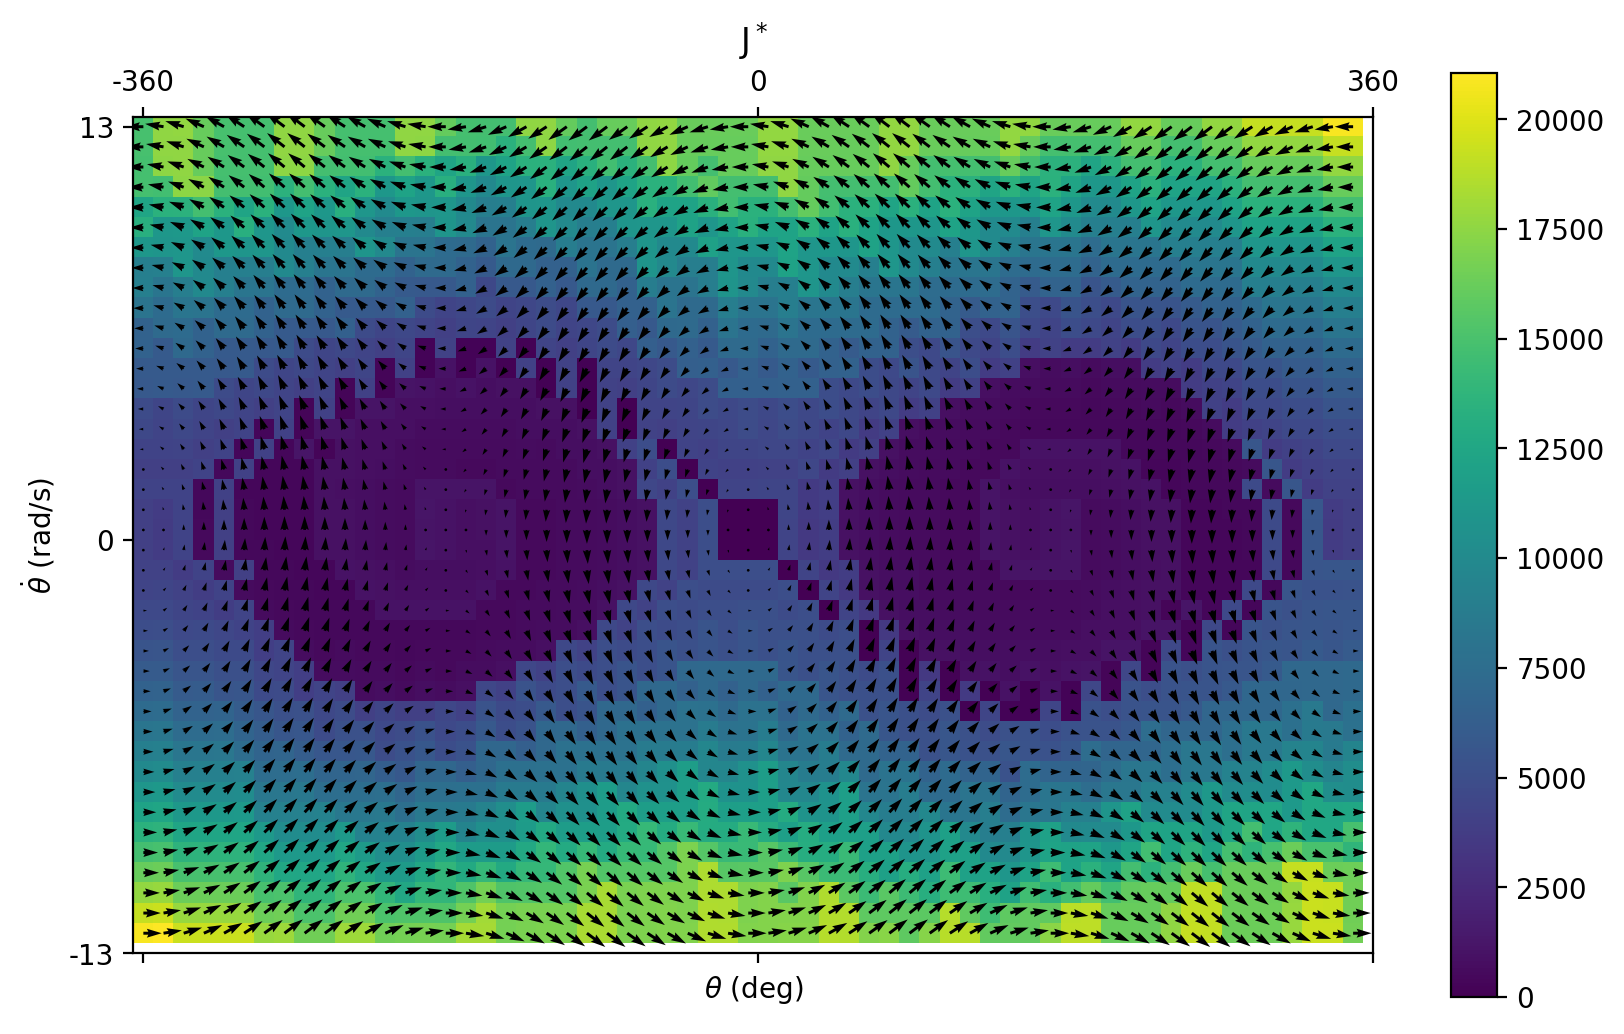

In [27]:
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = dynamics(0, (theta_space[row], thetadot_space[col]))[0]
        V[row, col] = -dynamics(0, (theta_space[row], thetadot_space[col]))[1]
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar.T[::-1],0)
plt.xticks((0, ntheta/2, ntheta), (-int(np.rad2deg(maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2, nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')
colorbar = plt.colorbar()
#colorbar.set_label(r'J$^*$')
plt.title(r'J$^*$');

In [22]:
Jstar = np.zeros((ntheta, nthetadot))
    
# do value iteration
for i in range(100):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_shifted_dynamics(0, q, u)
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell(q, u) + Jstar[new_Jstar_indices])
            Jstar[itheta, ithetadot] = min(J)

umax=0.05
[-0.05  0.    0.05]


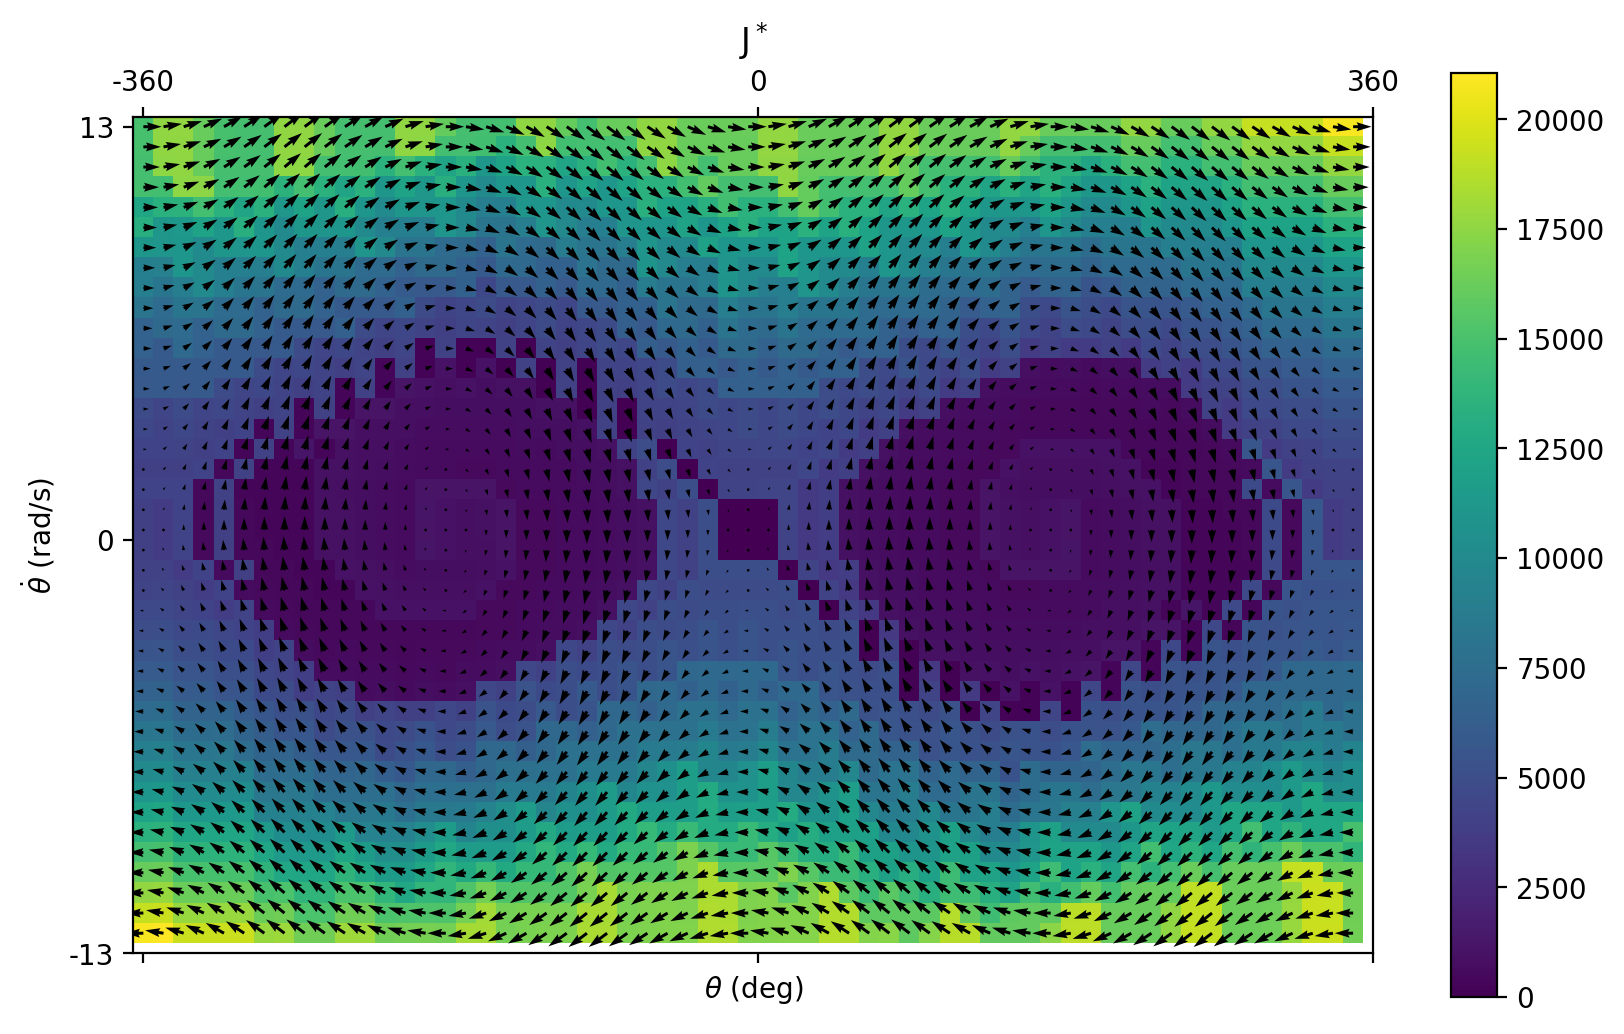

In [29]:
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = -shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
        V[row, col] = shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1]

#        U[row, col], V[row, col] = \
#            (-shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0],
#             shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1])
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar.T[::-1],0)
plt.xticks((0, ntheta/2, ntheta), (-int(np.rad2deg(maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2, nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')
colorbar = plt.colorbar()
#colorbar.set_label(r'J$^*$')
plt.title(r'J$^*$');

In [177]:
#u_space = np.linspace(-umax, umax, nu) 
u_space = (-.5,0, .5) 
Jstar_mintime = np.zeros((ntheta, nthetadot))
    
# do value iteration
for i in range(100):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_shifted_dynamics(0, q, u)
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell_mintime(q, u) + Jstar_mintime[new_Jstar_indices])
            Jstar_mintime[itheta, ithetadot] = min(J)

KeyboardInterrupt: 

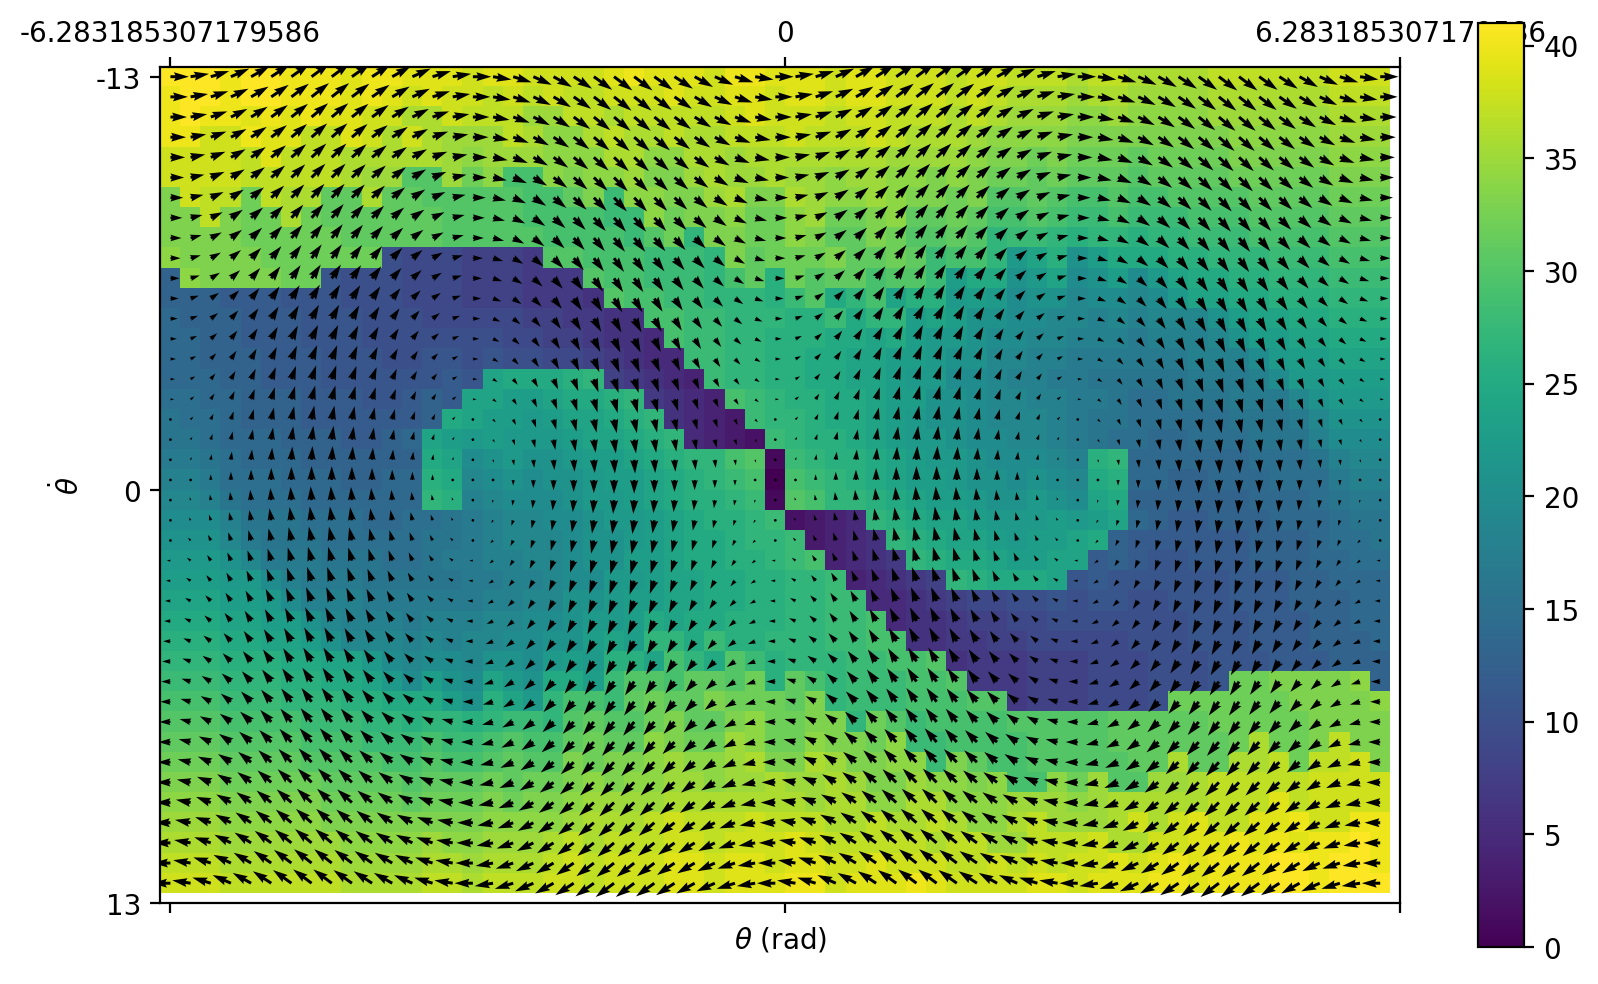

In [42]:
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(np.arange(ntheta), np.arange(nthetadot))
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = -shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[0]
        V[row, col] = shifted_dynamics(0, (theta_space[row], thetadot_space[col]))[1]
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar_mintime[:,::-1].T,0)
#plt.imshow(Jstar_mintime.T)
plt.xticks((0, ntheta/2, ntheta), (-maxtheta, 0, maxtheta))
plt.xlabel(r'$\theta$ (rad)')
plt.yticks((0, nthetadot/2, nthetadot), (-maxthetadot, 0, maxthetadot))
plt.ylabel(r'$\dot{\theta}$')
plt.colorbar()

The following cell takes minutes to run! skipping suggested

In [ ]:
# grid it out: 
ntheta = 101
theta_space = np.linspace(-maxtheta, maxtheta, ntheta)
theta_interpolator = sp.interpolate.interp1d(theta_space, range(ntheta), kind='nearest', fill_value='extrapolate')
nthetadot = 63
thetadot_space = np.linspace(-maxthetadot, maxthetadot, nthetadot)
thetadot_interpolator = sp.interpolate.interp1d(thetadot_space, range(nthetadot), kind='nearest', fill_value='extrapolate')
deltathetadotmax = 10 # distance along vertical direction u can act
nu = 2*deltathetadotmax+1
umax = m * l**2 / dt * deltathetadotmax
print(f'{umax=}')
#u_space = np.linspace(-int(nu/2), int(nu/2), nu) 
u_space = np.linspace(-umax, umax, nu) 
Jstar = np.zeros((ntheta, nthetadot))


    
# do value iteration
for i in range(50):
    for itheta, theta in enumerate(theta_space):
        for ithetadot, thetadot in enumerate(thetadot_space):
            # find u that minimizes 
            J = []
            q = (theta, thetadot)
            for u in u_space:
                new_q = discrete_linearized_dynamics(0, q, (u,))
                new_Jstar_indices = (int(theta_interpolator(new_q[0])), int(thetadot_interpolator(new_q[1])))
                J.append(ell(q, u) + Jstar[new_Jstar_indices])
            Jstar[itheta, ithetadot] = min(J)

In [ ]:
plt.figure(figsize=(10, 6))
ntheta = 31
theta_space = np.linspace(-maxtheta, maxtheta, ntheta)
nthetadot = 21
thetadot_space = np.linspace(-maxthetadot, maxthetadot, nthetadot)
X, Y = np.meshgrid(np.arange(ntheta)*101/ntheta, np.arange(nthetadot)*61/nthetadot)
U, V = np.empty((ntheta, nthetadot)), np.empty((ntheta, nthetadot)) 
for row in range(ntheta):
    for col in range(nthetadot):
        U[row, col] = -discrete_linearized_dynamics(0, (theta_space[row], thetadot_space[col]))
        V[row, col] = discrete_linearized_dynamics(0, (theta_space[row], thetadot_space[col]))
plt.quiver(X.T, Y.T, U, V)
plt.matshow(Jstar.T[:5:-1],0)
plt.xticks((0, ntheta/2*101/ntheta, ntheta*101/ntheta), (-int(np.rad2deg(maxtheta)), 0, int(np.rad2deg(maxtheta))))
plt.xlabel(r'$\theta$ (deg)')
plt.yticks((0, nthetadot/2*61/nthetadot, nthetadot*61/nthetadot), (maxthetadot, 0, -maxthetadot))
plt.ylabel(r'$\dot{\theta}$ (rad/s)')
colorbar = plt.colorbar()
colorbar.set_label(r'J$^*$')
#plt.title(r'J$^*$');